In [1]:
import fenics as fn
import numpy as np
from scipy import constants as phys
from matplotlib import pyplot as plt

In [2]:
print(phys.R)
print(phys.physical_constants['Faraday constant']) # (value, unit, uncertainty)

8.314462618
(96485.33212, 'C mol^-1', 0.0)


In [3]:
z1 = 1.
z2 = -1.
R  = 8.314  # J/mol*K (gas constant)
F  = 96485. # C/mol   (Faraday's constant)

In [4]:
# Table IV. Base case simulation parameters.
c0    = 500.     # mol/m^3        (Initial concentration of electrolyte)
D1    = 4.e-10   # m^2/s          (Diffusivity of Li+)
D2    = 4.e-9    # m^2/s          (Diffusivity of PF6-)
Iapp  = 10.0     # A/m^2          (Applied current density)
L     = 7.5e-4   # m              (Cell dimension on x)
T     = 298.15   # K              (Temperature)
eps_0 = 8.85e-12 # s^4*A^2/kg*m^3 (Vacuum permitivity)
eps_s = 16.8     # -              (Dielectric constant of the solvent)

In [5]:
D = 2*D1*D2/(D1 + D2)
print(D)

7.272727272727273e-10


In [6]:
t_test   = np.array([1,6,36,100,3600])
tau_test = D*t_test/(L**2)
print(t_test)
print(tau_test)
#
t_vector   = np.linspace(0,3600,4*3600+1)
tau_vector = D*t_vector/(L**2)
print(t_vector[:5])

[   1    6   36  100 3600]
[1.29292929e-03 7.75757576e-03 4.65454545e-02 1.29292929e-01
 4.65454545e+00]
[0.   0.25 0.5  0.75 1.  ]


In [7]:
#tau_vector = np.linspace(0.,1.,1001)

In [8]:
dt = t_vector[1]
dtau = tau_vector[1]

In [9]:
delta = Iapp*L/(z1*F*c0*D1)
print(delta)

0.38866144996631596


In [10]:
def analytical_sol(X,tau,delta,n=5):
    C = 0.
    for idx in range(1,n+1):
        C += delta*(-1 + np.cos(idx*np.pi))*np.cos(idx*np.pi*X)*np.exp(-(idx*np.pi)**2*tau)/((idx*np.pi)**2)
    C += 1 + delta/4 - delta*X/2
    return C

In [11]:
X_vector = np.linspace(0.,1.,125)

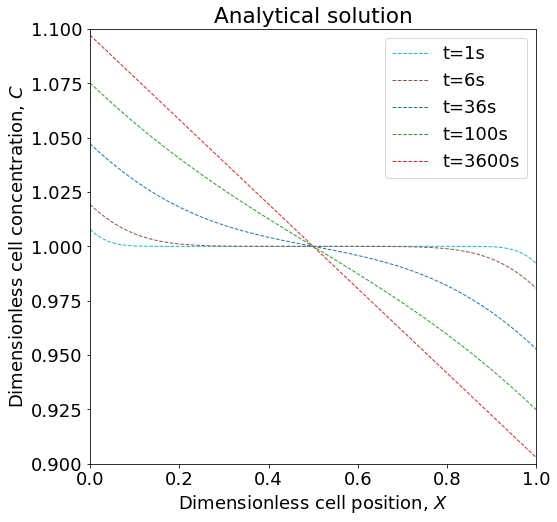

In [12]:
plt.figure(figsize=(8,8))
#
plt.rcParams.update({'font.size': 18})
#
color_str = ['tab:cyan','tab:brown','tab:blue','tab:green','tab:red']
idx = 0
for tau in tau_test:
    #t = 0.1
    t_str = 't='+str(int(tau*L**2/D))+'s'
    plt.plot(X_vector,analytical_sol(X_vector,tau,delta,n=100),
             linewidth=1.0, 
             linestyle='--', 
             color=color_str[idx],
             label=t_str)
    idx += 1
#plt.plot(X_vector, -delta*X_vector/2 + 1 + delta/4,
#         linewidth=1.0, 
#         color='black',
#         linestyle='--',
#         label=r't=$\infty$')
plt.xlim(0.,1.)
plt.ylim(0.9,1.1)
plt.title('Analytical solution')
plt.xlabel('Dimensionless cell position, $X$')
plt.ylabel('Dimensionless cell concentration, $C$')
plt.legend()
plt.show()

# Finite Element

In [13]:
mesh = fn.UnitIntervalMesh(128)
Un   = fn.FunctionSpace(mesh, "CG", 1)
#Vn   = fn.FunctionSpace(mesh, "CG", 1)

In [14]:
un = fn.TrialFunction(Un)
#wn = fn.TestFunction(Un)
#rn = fn.TrialFunction(Vn)
vn = fn.TestFunction(Un)

In [15]:
u0 = fn.Function(Un)
u0.vector()[:] = 1.

In [16]:
#
sol_list = []
#
B  = un*vn*(fn.dx) + (dtau)*fn.dot(fn.grad(un),fn.grad(vn))*(fn.dx)
BB = fn.assemble(B).array()
#
delta0 = fn.PointSource(Un, fn.Point(0.0), dtau*delta/2)
delta1 = fn.PointSource(Un, fn.Point(1.0), -dtau*delta/2)
#
for idx in range(tau_vector.shape[0]):    
    #print(idx)    
    l  = u0*vn*(fn.dx)
    LL = fn.assemble(l)
    delta0.apply(LL)
    delta1.apply(LL)
    #
    sol = np.linalg.solve(BB,LL[:])
    #print(sol(0.0))
    #
    u1 = fn.Function(Un)
    u1.vector()[:] = sol
    #
    u0.vector()[:] = u1.vector()[:]
    #
    sol_list.append(u1.vector()[:])     
#return sol_list

Calling FFC just-in-time (JIT) compiler, this may take some time.


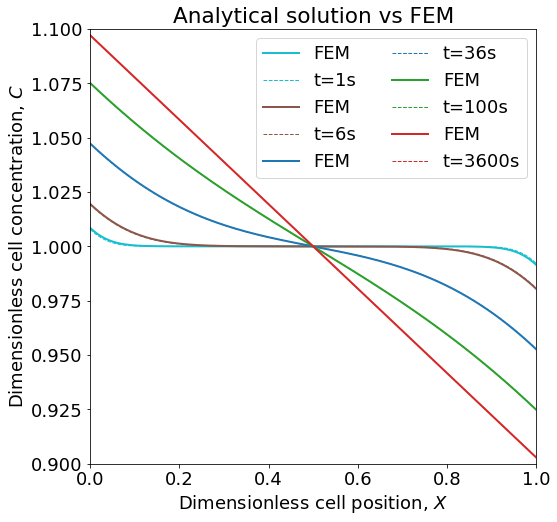

In [18]:
plt.figure(figsize=(8,8))
#
plt.rcParams.update({'font.size': 18})
#
color_str = ['tab:cyan','tab:brown','tab:blue','tab:green','tab:red']
#
for idx in range(tau_test.shape[0]):
    tau_idx = np.where(tau_vector == tau_test[idx])[0][0]
    #
    u_sol = fn.Function(Un)
    u_sol.vector()[:] = sol_list[tau_idx]
    #
    fn.plot(u_sol,linewidth=2.0,color=color_str[idx],label='FEM')
    #
    t_str = 't='+str(int(tau_test[idx]*L**2/D))+'s'
    plt.plot(X_vector,analytical_sol(X_vector,tau_test[idx],delta,n=100),
             linewidth=1.0, 
             linestyle='--',
             #marker='o',
             color=color_str[idx],
             label=t_str)
#
plt.xlim(0.,1.)
plt.ylim(0.9,1.1)
plt.xlabel('Dimensionless cell position, $X$')
plt.ylabel('Dimensionless cell concentration, $C$')
plt.title('Analytical solution vs FEM')
plt.legend(ncol=2)
plt.show()

<b>Observations:</b> The FE solution can be improved with smaller step on time

<h2>Error estimation</h2>

In [19]:
x_vector = np.linspace(0.,1.,1024)

In [24]:
error_list = []
for idx in range(tau_test.shape[0]):
    tau_idx = np.where(tau_vector == tau_test[idx])[0][0]
    #
    u_sol = fn.Function(Un)
    u_sol.vector()[:] = sol_list[tau_idx]
    #
    u_exa = analytical_sol(x_vector,tau_test[idx],delta,n=100)
    error = 0.
    for i in range(x_vector.shape[0]):
        error += ((u_sol(x_vector[i]) - u_exa[i])/u_exa[i])**2
    #
    error = 100*np.sqrt(error)
    error_list.append(error)

In [27]:
i = 0
for tau in tau_test:
    t_str = 't='+str(int(tau*L**2/D))+'s'
    print(f"Solution for {t_str} has a relative error of: {error_list[i]}%")
    i += 1

Solution for t=1s has a relative error of: 0.8258400054055416%
Solution for t=6s has a relative error of: 0.5394878657797346%
Solution for t=36s has a relative error of: 0.27906734875690486%
Solution for t=100s has a relative error of: 0.060824418117195175%
Solution for t=3600s has a relative error of: 4.749088427557151e-09%
